### Loading Vader dataset fold 0 into X, y

In [1]:
%%time
import gzip
import numpy as np

# Load and decode in one pass
with gzip.open("data/train0.gz", "rb") as fd:
    content = [line.decode('utf-8').strip().split(' ') for line in fd]

# Preallocate labels and features
num_samples = len(content)
num_features = len(content[0]) - 1

labels = np.empty(num_samples, dtype=int)
features = np.empty((num_samples, num_features), dtype=float)

# Efficient parsing
for i, row in enumerate(content):
    labels[i] = int(row[0])
    for j, feat in enumerate(row[1:]):
        features[i, j] = float(feat.split(':')[1])

X = features
y = labels

print(type(y))
print(y[0:10])
print(type(X))
print(X[0])


<class 'numpy.ndarray'>
[1 1 1 0 0 0 0 1 0 1]
<class 'numpy.ndarray'>
[-0.32730305 -3.1321497   1.70186234 ...  0.97825307 -0.18393582
 -1.62006617]
CPU times: total: 45.7 s
Wall time: 49.4 s


### Reduce to 2D with PCA and visualizing the data

(3956, 2)
[34.62419128  3.19151544]


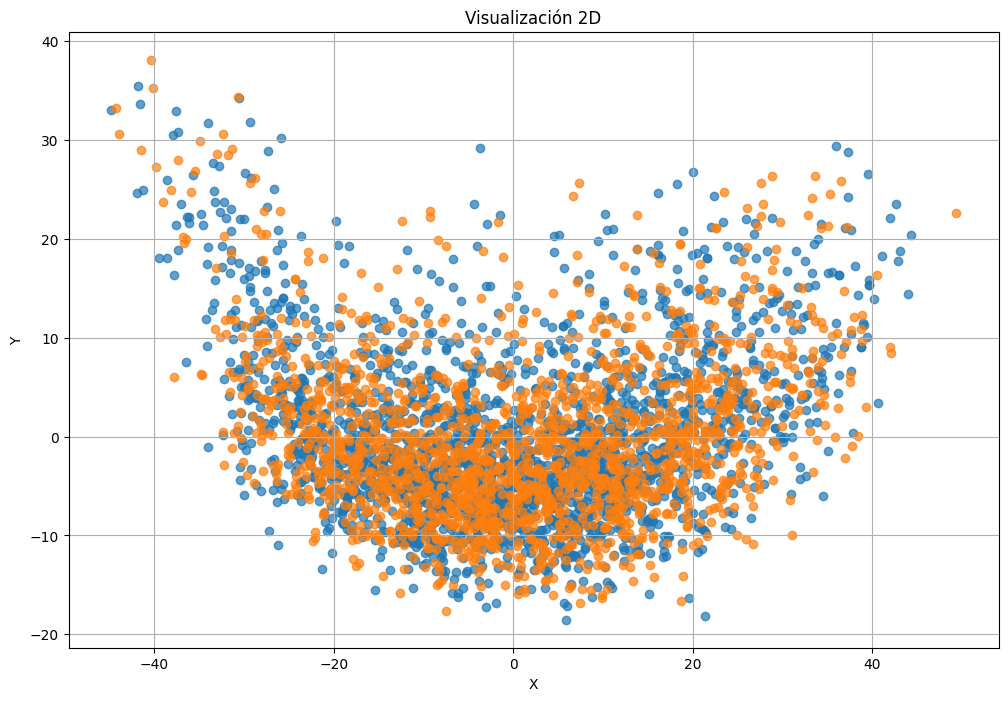

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

def plot_embs_2d(X, y, kept_indices=None):

    if(kept_indices is None):
        kept_indices = np.arange(len(X), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca.fit(X[kept_indices])
    X_pca = pca.transform(X[kept_indices])
    print(X_pca.shape)
    print(X_pca[0])

    # Plot
    plt.figure(figsize=(12, 8))
    for i in range(2): # 2 classes
        plt.scatter(X_pca[y[kept_indices] == i, 0], X_pca[y[kept_indices] == i, 1], label=f'Class {i}', alpha=0.7)  
        
    plt.title(f"Visualización 2D")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_embs_2d(X, y)

### Formulating the QUBO problem

#### 1. Precomputing distances and nearest ennemies

In [3]:
%%time

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

distances = euclidean_distances(X, X)
print(distances[:1])

[[ 0.         49.09521747 56.06615433 ... 48.73090446 49.00718211
  64.87739052]]
CPU times: total: 5.73 s
Wall time: 1.37 s


In [4]:
%%time

def ne_dist(labels, distances):
    '''
    Vectorized Nearest Enemy computation.
    '''
    labels = np.array(labels)
    n = len(labels)
    ne = np.full(n, -1, dtype=int)

    # Create a mask where entries are True if the pair has different labels
    enemy_mask = labels[:, None] != labels[None, :]

    # Set same-class distances to np.inf to ignore them
    masked_distances = np.where(enemy_mask, distances, np.inf)

    # Find the index of the minimum distance in each row
    ne = np.argmin(masked_distances, axis=1)

    return ne

nenemies_dist = ne_dist(y, distances)

CPU times: total: 156 ms
Wall time: 171 ms


#### 2. Noise Filtering with LSSm

In [5]:
def compute_local_sets(labels, ne, distances, kept_indices=None):
    '''
    Compute local sets and sort them by increasing Local Set Cardinality (LSC),
    restricted to instances in `kept_indices`.

    Parameters:
    - labels: (n,) full label array
    - ne: (n,) nearest enemy indices in original space
    - distances: (n, n) full pairwise distance matrix
    - kept_indices: list or array of indices to keep (subset of full data)

    Returns:
    - LSs: dict of local sets for each kept index
    - sorted_LSs_dict: dict of kept index → local set (sorted by LSC)
    '''
    from collections import defaultdict
    import numpy as np

    if(kept_indices is None):
        kept_indices = np.arange(len(labels), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)
        
    labels = np.array(labels)
    ne = np.array(ne)
    distances = np.array(distances)

    LSs = defaultdict(list)
    lsc_map = []

    for i in kept_indices:
        # Only consider other kept instances
        same_class = (labels[kept_indices] == labels[i])
        closer_than_enemy = (distances[i][kept_indices] <= distances[i][ne[i]])
        mask = same_class & closer_than_enemy
        LS = kept_indices[mask].tolist()

        # Ensure i is included if appropriate
        if i not in LS:
            LS.append(i)

        LSs[int(i)] = LS
        lsc_map.append((int(i), len(LS)))

    # Sort by increasing local set size
    lsc_map.sort(key=lambda x: x[1])

    # Create sorted dict
    sorted_LSs_dict = defaultdict(list)
    for i, _ in lsc_map:
        sorted_LSs_dict[int(i)] = LSs[int(i)]

    return LSs, sorted_LSs_dict

In [6]:
%%time

def local_set_based_smoother(X, y, ne, distances):
    """
    Local Set Based Smoother (noise filtering).
    
    Keeps points where the number of local sets the point appears in 
    is greater than the number of times it is a nearest enemy.

    Parameters:
    - X: (n_samples, n_features) data array
    - y: (n_samples,) label array
    - ne: (n_samples,) index of nearest enemy for each point
    - distances: (n_samples, n_samples) full pairwise distance matrix

    Returns:
    - kept_indices: indices of retained points (relative to original X)
    """
    import numpy as np
    from collections import defaultdict

    n = len(y)
    LSs, _ = compute_local_sets(y, ne, distances)

    # Count how many local sets each point appears in
    LS_count = np.zeros(n, dtype=int)
    for LS in LSs.values():
        for idx in LS:
            LS_count[idx] += 1

    # Count how many times each point is the nearest enemy
    NE_count = np.zeros(n, dtype=int)
    for enemy in ne:
        NE_count[enemy] += 1

    # Apply the smoother condition
    mask = LS_count > NE_count
    kept_indices = np.where(mask)[0]

    return kept_indices

kept_indices = local_set_based_smoother(X, y, nenemies_dist, distances)

CPU times: total: 1.78 s
Wall time: 1.8 s


#### 3. Precomputing Local Sets and performing clustering based on Local Sets

In [7]:
%%time

LSs, sorted_LSs_dict = compute_local_sets(y, nenemies_dist, distances, kept_indices) 

print(len(LSs))
print(list(LSs.keys())[0:10])
print(list(LSs.values())[0:10])
print()
print(len(sorted_LSs_dict))
print(list(sorted_LSs_dict.keys())[0:10])
print(list(sorted_LSs_dict.values())[0:10])

3092
[0, 1, 4, 5, 6, 8, 9, 10, 11, 12]
[[0], [1, 2056], [4, 2985], [5, 426, 2344, 2601], [6, 167, 3193, 3482], [8, 1549, 3320, 3912], [9, 14], [10, 3504], [11], [12, 2152]]

3092
[0, 11, 13, 14, 16, 22, 37, 38, 43, 50]
[[0], [11], [13], [14], [16], [22], [37], [38], [43], [50]]
CPU times: total: 250 ms
Wall time: 314 ms


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from collections import defaultdict
import random


random_state=0

random.seed(random_state)

num_points = 200
num_classes = 2

X_2d_example, y_2d_example = make_blobs(n_samples=num_points, centers=num_classes, n_features=2,
                  random_state=random_state, cluster_std= 2.5)

print(len(X_2d_example))
print(len(y_2d_example))

200
200


(200, 2)
[1.52123787 2.33613844]


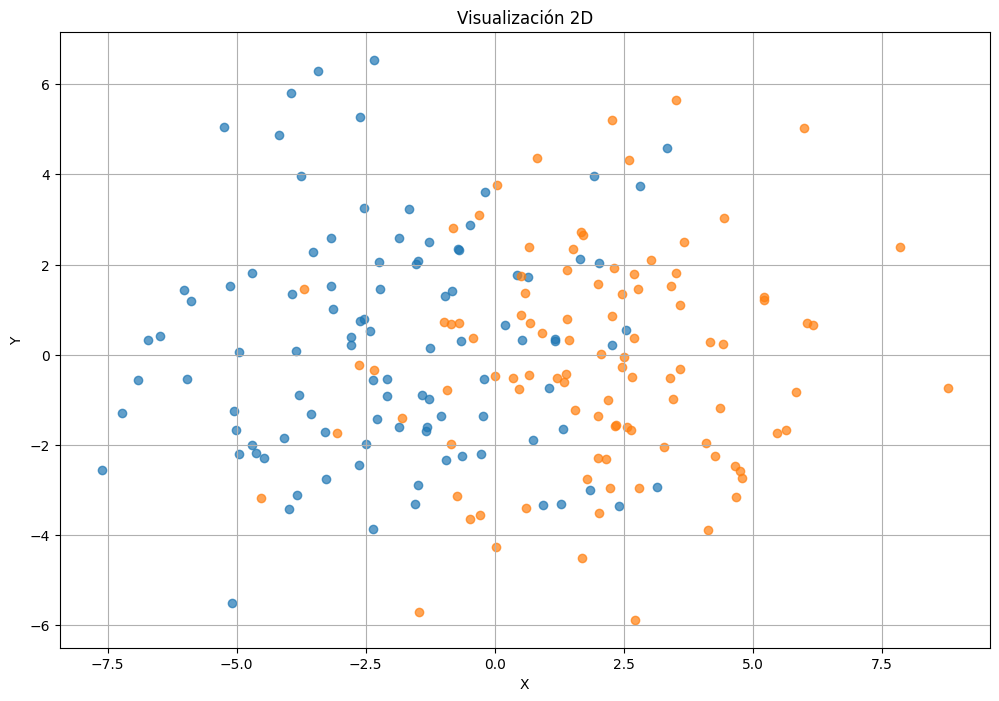

In [21]:
plot_embs_2d(X_2d_example, y_2d_example)

In [22]:
distances_2d_example = euclidean_distances(X_2d_example, X_2d_example)
nenemies_dist_2d_example = ne_dist(y_2d_example, distances_2d_example)
kept_indices_2d_example = local_set_based_smoother(X_2d_example, y_2d_example, nenemies_dist_2d_example, distances_2d_example)
print(len(kept_indices_2d_example))

161


(161, 2)
[1.42347532 2.49870837]


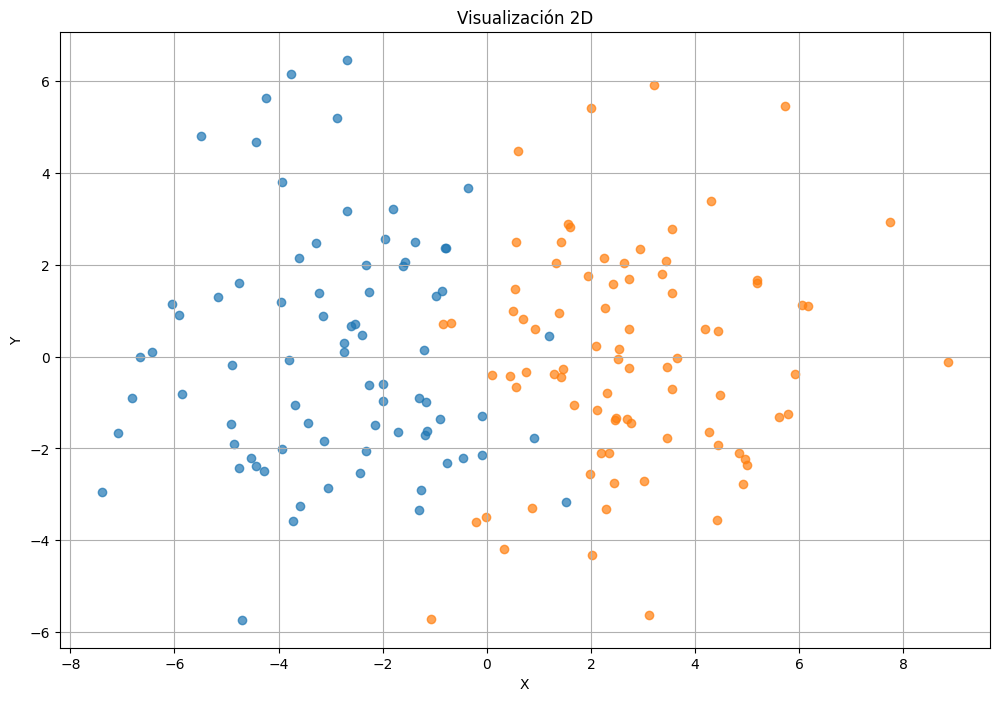

In [23]:
plot_embs_2d(X_2d_example, y_2d_example, kept_indices_2d_example)

In [24]:
LSs_2d_example, sorted_LSs_dict_2d_example = compute_local_sets(y_2d_example, nenemies_dist_2d_example, distances_2d_example, kept_indices_2d_example) 

In [25]:
%%time

from collections import defaultdict

def LS_based_clustering_INVERSE(sorted_LSs_dict, LSs): 
    '''
    Inverse Local Set Based Clustering: 
        Assigns each instance to the cluster of the medoid with the smallest local set cardinality that contains it 
        — i.e., inverse local set clustering.
    '''
    clusters = defaultdict(list)
    included_instances = set()

    # Process clusters from lowest to highest LSC
    for LS_key in sorted_LSs_dict.keys():
        if LS_key not in included_instances:
            cluster_instances = set(LSs[LS_key]) - included_instances
            included_instances.update(cluster_instances)
            clusters[LS_key] = list(cluster_instances)

    return clusters

clusters_inverse = LS_based_clustering_INVERSE(sorted_LSs_dict, LSs)
clusters_inverse_2d_example = LS_based_clustering_INVERSE(sorted_LSs_dict_2d_example, LSs_2d_example)

CPU times: total: 15.6 ms
Wall time: 8.02 ms


In [15]:
print(clusters_inverse)

defaultdict(<class 'list'>, {0: [0], 11: [11], 13: [13], 14: [14], 16: [16], 22: [22], 37: [37], 38: [38], 43: [43], 50: [50], 52: [52], 57: [57], 61: [61], 67: [67], 70: [70], 74: [74], 75: [75], 77: [77], 83: [83], 87: [87], 91: [91], 96: [96], 102: [102], 105: [105], 111: [111], 113: [113], 114: [114], 115: [115], 117: [117], 124: [124], 125: [125], 130: [130], 131: [131], 136: [136], 137: [137], 139: [139], 145: [145], 147: [147], 149: [149], 153: [153], 154: [154], 157: [157], 163: [163], 164: [164], 166: [166], 168: [168], 169: [169], 170: [170], 171: [171], 178: [178], 180: [180], 183: [183], 184: [184], 191: [191], 192: [192], 196: [196], 199: [199], 200: [200], 210: [210], 211: [211], 213: [213], 214: [214], 220: [220], 222: [222], 226: [226], 227: [227], 230: [230], 238: [238], 239: [239], 247: [247], 248: [248], 249: [249], 250: [250], 251: [251], 253: [253], 254: [254], 262: [262], 263: [263], 267: [267], 268: [268], 273: [273], 276: [276], 277: [277], 278: [278], 281: [281

C:\Users\Usuario\AppData\Local\Temp\ipykernel_23772\1249948363.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', num_clusters)  # color for clusters


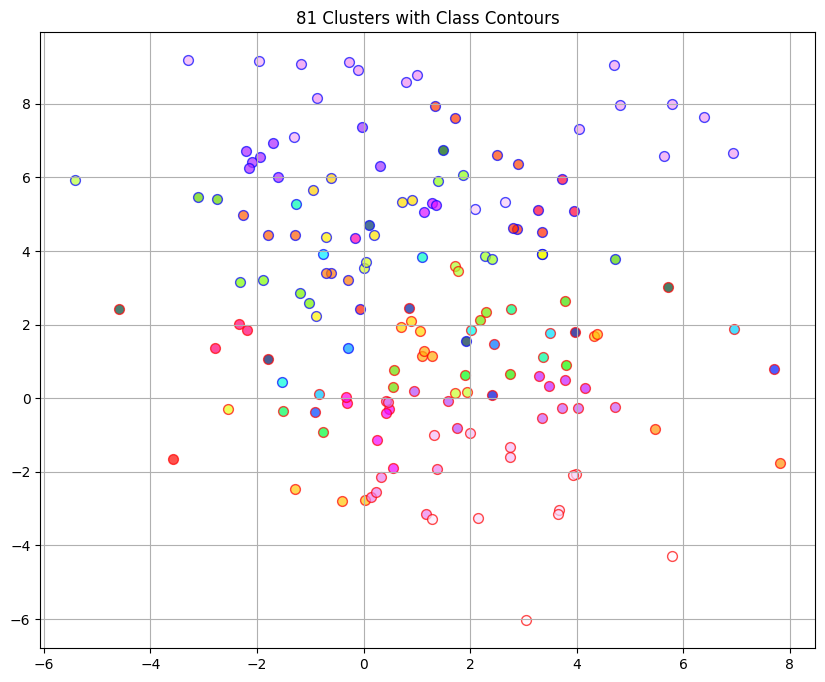

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_clusters(clusters: defaultdict, X: np.ndarray, labels: np.ndarray):
    """
    Plots clustered points with cluster-based colors and label-based contours.
    
    Parameters:
    - clusters: defaultdict of cluster_id -> list of point indices
    - X: np.ndarray of shape (n_samples, 2), the 2D coordinates of all points
    - labels: np.ndarray of shape (n_samples,), containing binary class labels (0 or 1)
    """
    num_clusters = len(clusters)
    cmap = plt.cm.get_cmap('gist_ncar', num_clusters)  # color for clusters
    edge_colors = {0: 'blue', 1: 'red'}  # edge colors for labels
    
    plt.figure(figsize=(10, 8))
    
    for i, (cluster_id, indices) in enumerate(clusters.items()):
        cluster_points = X[indices]
        cluster_labels = labels[indices]
        
        for j, point in enumerate(cluster_points):
            label = cluster_labels[j]
            plt.scatter(point[0], point[1],
                        color=cmap(i),            # cluster color
                        edgecolor=edge_colors[label],  # label edge color
                        linewidth=1,
                        s=50,
                        alpha=0.7)
    
    plt.title(f"{num_clusters} Clusters with Class Contours")
    plt.grid('on')
    plt.show()


plot_clusters(clusters_inverse_2d_example, X_2d_example, y_2d_example)

In [35]:
print(len(clusters_inverse))
print(len(LSs))

2542
3092


In [ ]:
#### 5. Preselecting clusters to fit in the number of decision variables

In [ ]:
num_decision_variables = 150
size = min(len(clusters_inverse_clean), num_decision_variables)
print(f'initial number of clusters: {len(clusters_inverse_clean)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

#### 4. QUBO matrix definition

As we already did noise removal, here we are focused on removing redundancy (QUBO matrix that selects clusters likely near class boundaries)

In [ ]:
from collections import defaultdict
import numpy as np

# Mock definitions (for testing)
# These should be replaced with real data structures in use
# clusters_filtered: dict[int, list[int]]
# has_ne_of: 2D numpy array, has_ne_of[i][j] == 1 if j is a nearest enemy of i

def compute_border_scores(clusters_filtered, has_ne_of):
    border_score = {}
    for i, cluster_points in clusters_filtered.items():
        score = 0
        for p in cluster_points:
            for q in range(has_ne_of.shape[1]):
                if q not in cluster_points:
                    score += has_ne_of[p][q]
        border_score[i] = score
    return border_score

def compute_redundancy_scores(clusters_filtered, selected_y, medoid_indices, threshold_distance=0.1):
    # Example redundancy: overlap in members + close medoids with same class
    num_clusters = len(clusters_filtered)
    redundancy = defaultdict(lambda: defaultdict(float))

    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            set_i = set(clusters_filtered[i])
            set_j = set(clusters_filtered[j])
            overlap = len(set_i & set_j)

            # Simple distance-based proximity using medoids
            same_class = selected_y[medoid_indices[i]] == selected_y[medoid_indices[j]]
            # Here you would use actual distance between medoid embeddings if available
            proximity = 1.0 if same_class else 0.0  # Placeholder, replace with actual check

            redundancy[i][j] = overlap + proximity

    return redundancy

def construct_qubo_matrix(border_score, redundancy, num_clusters, alpha=1.0, beta=1.0, gamma=0.0, k=None):
    Q = defaultdict(float)

    for i in range(num_clusters):
        Q[(i, i)] = -alpha * border_score[i] + gamma  # Border term + optional cardinality constraint
        if k is not None:
            Q[(i, i)] += -2 * k * gamma  # Fixed cardinality constraint

        for j in range(i + 1, num_clusters):
            Q[(i, j)] = beta * redundancy[i][j] + 2 * gamma  # Redundancy + constraint

    return Q

# Example usage:
# border_score = compute_border_scores(clusters_filtered, has_ne_of)
# redundancy = compute_redundancy_scores(clusters_filtered, selected_y, medoid_indices)
# Q = construct_qubo_matrix(border_score, redundancy, len(clusters_filtered), alpha=1.0, beta=1.0, gamma=1.0, k=10)



In [ ]:
has_ne_of = [[0 for _ in range(size)] for _ in range(size)]
has_LS_member = [[0 for _ in range(size)] for _ in range(size)]

for i in range(size):
    cluster_i_components = list(clusters_preselected.values())[i]

    for j in range(i+1, size): # for each different pair of clusters
        cluster_j_components = list(clusters_preselected.values())[j]
        for comp_i in cluster_i_components:
            for comp_j in cluster_j_components:  

                    if(nenemies_dist[comp_j] == comp_i): # cluster i has a ne of cluster j
                        has_ne_of[i][j] = has_ne_of[i][j] + 1 
                        
                    if(nenemies_dist[comp_i] == comp_j): # cluster j has a ne of cluster i
                        has_ne_of[j][i] = has_ne_of[j][i] + 1 
                        
                    if(comp_i in LSs[comp_j]): # cluster i has a member of a LS of cluster j
                        has_LS_member[i][j] = has_LS_member[i][j] + 1
                        
                    if(comp_j in LSs[comp_i]): # cluster j has a member of a LS of cluster i
                        has_LS_member[j][i] = has_LS_member[j][i] + 1 
                    

print(f'cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): \n {np.array(has_ne_of)}')
print()
print(f'cluster members of LSs of other clusters: \n {np.array(has_LS_member)}') 

In [ ]:
total_cluster_nes = list(map(sum, has_ne_of))
total_cluster_LSs_members = list(map(sum, has_LS_member)) 
#cluster_noise_score = list(map(lambda a, b: a-b, total_cluster_ne, total_cluster_LS))

has_a_ne = list(map(lambda a: 0 if a == 0 else 1, total_cluster_nes))
has_a_LS_member = list(map(lambda a: 0 if a == 0 else 1, total_cluster_LSs_members))

print(f'total cluster nearest ennemies: \n {np.array(total_cluster_nes)}')
print()
print(f'total cluster members belonging to Local Sets: \n {np.array(total_cluster_LSs_members)}') 
print()
print(f'clusters having nearest ennemies: \n {np.array(has_a_ne)}')
print()
print(f'clusters having members belonging to Local Sets: \n {np.array(has_a_LS_member)}')   

In [ ]:
clusters_filtered = defaultdict(list)
filtered_keys = list(map(lambda key, LS_members, nearest_ennemies: key if LS_members >= nearest_ennemies else -1, clusters_preselected.keys(), total_cluster_LSs_members, total_cluster_nes))
print(filtered_keys)

In [ ]:
# sort keys by cluster cardinality
key_cardinality = list(map(lambda key, value: [key, len(value)], list(clusters_inverse_clean.keys()), list(clusters_inverse_clean.values())))
key_cardinality_inverse = list(map(lambda row: [row[1],row[0]], key_cardinality))
key_cardinality_inverse.sort()

In [ ]:
clusters_preselected = defaultdict(list)
for i in range(size):
    key = key_cardinality_inverse[i][1]
    clusters_preselected[key] = clusters_inverse_clean[key]
print(clusters_preselected)
print(len(clusters_preselected))

In [ ]:
dataset = # Reading the dataset

# submission file: config/workspace/submissions/[Dataset]_[FoldNumber]_[Method]_[Groupname]_[SubmissionID].txt

filename="/submissions/Vader_0_SA_gplsi_LocalSets.txt" # Please, follow the file name format provided in the task description: [Dataset]_[FoldNumber]_[Method]_[Groupname]_[SubmissionID].txt . 
# Note that the SubmissionID is not the one reported in the last line of this cell. It is a custom ID that you give to represent your submission.
# For example, if you decide to use a method called 'AlgorithmX', you can give as SubmissionID your 'AlgorithmX'. The same 'AlgorithmX' must be used for both
# quantum and traditional submissions for comparison.


sampleset=qa.submit(EmbeddingComposite(DWaveSampler()), EmbeddingComposite.sample, bqm, label='2 Your Label', num_reads=100 ) 
# Please, do the same for Simulated Annealing as well for comparison.

solution=sampleset.first.sample 
docs_to_keep=[] 
for doc,selected in best_solution.items(): 
    if(selected==1): 
        docs_to_keep.append(doc) 

submission="" 
for i,doc in enumerate(docs_to_keep): 
    submission+=str(doc)+"\n" 
    
ids=[sampleset.info['problem_id']] # The ids can be retrieved also from your dashboard. These should be reported in the last line of your submission file as a list of ids.
submission+=str(ids)
